In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

from torch import nn

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [2]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=False,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=False,
    transform=ToTensor()
)

print('Shape of image:', training_data[0][0].shape)

train_dataloader = DataLoader(training_data, batch_size=32)
test_dataloader = DataLoader(test_data, batch_size=32)



Shape of image: torch.Size([1, 28, 28])


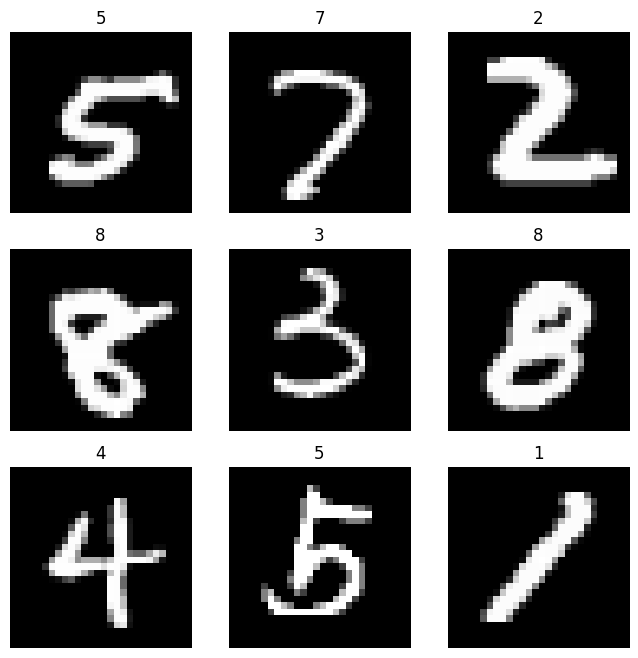

In [3]:
labels_map = {
    0: '0',
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5',
    6: '6',
    7: '7',
    8: '8',
    9: '9',
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# Build the Model #


In [4]:
# This would be stored in models.py 

class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, 10),
            nn.ReLU(),
            nn.Dropout(0.5),

        )

        self.decoder = nn.Sequential(
            nn.Linear(10, 32),
            nn.ReLU(), 
            nn.Dropout(0.5),
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256,512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 28*28),
            nn.Sigmoid()

        )

    def encode(self, x):
        x = self.flatten(x)
        z = self.encoder(x)
        return z
    
    def decode(self, z):
        logits = self.decoder(z)
        return logits
    
    def forward(self, x):
        z = self.encode(x)
        logits = self.decode(z)
        return logits

In [5]:
model = AutoEncoder().to(device)
print(model)

AutoEncoder(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=128, out_features=32, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=32, out_features=10, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.5, inplace=False)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=32, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=128, out_features=256, bias=True)
    (7)

Text(0.5, 1.0, 'Model Output (untrained)')

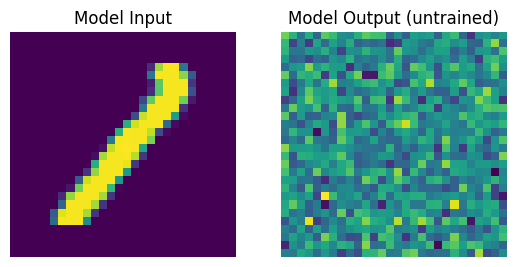

In [6]:
examp_img, examp_label =  training_data[sample_idx]


device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
examp_img_device = examp_img.to(device)
model = AutoEncoder().to(device)


examp_output = model(examp_img_device)
examp_output_cpu = examp_output.cpu().detach().numpy()

fig, ax = plt.subplots(1,2)
ax[0].imshow(np.squeeze(np.array(examp_img)))
ax[0].axis('off')
ax[0].set_title('Model Input')
ax[1].imshow(np.reshape(np.squeeze(np.array(examp_output_cpu)), (28,28)))
ax[1].axis('off')
ax[1].set_title('Model Output (untrained)')

# Train da model #


In [7]:
learning_rate = 1e-4
epochs = 1
batch_size= 32

loss = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
# Copied from the Pytorch Tutoria;l

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, _) in enumerate(dataloader):
        # Compute prediction and loss
        # Move data to the device
        X = X.to(device)
        pred = model(X)
        loss = loss_fn(pred, X.view(-1,28*28))

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, _ in dataloader:
            # Move data to the device
            X = X.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, X.view(-1,28*28)).item()

    test_loss /= num_batches
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")


In [10]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")



Epoch 1
-------------------------------
loss: 0.061488  [   32/60000]
loss: 0.056527  [ 3232/60000]
loss: 0.063068  [ 6432/60000]
loss: 0.062996  [ 9632/60000]
loss: 0.057373  [12832/60000]
loss: 0.062757  [16032/60000]
loss: 0.072019  [19232/60000]
loss: 0.065201  [22432/60000]
loss: 0.061563  [25632/60000]
loss: 0.060880  [28832/60000]
loss: 0.063880  [32032/60000]
loss: 0.061343  [35232/60000]
loss: 0.060316  [38432/60000]
loss: 0.062728  [41632/60000]
loss: 0.056761  [44832/60000]
loss: 0.068169  [48032/60000]
loss: 0.072211  [51232/60000]
loss: 0.059284  [54432/60000]
loss: 0.059725  [57632/60000]
Test Error: 
 Avg loss: 0.065997 

Done!


In [11]:
# Save the trained model
torch.save(model.state_dict(), 'autoencoder.pth')
print("Model saved as 'autoencoder.pth'")

Model saved as 'autoencoder.pth'


In [16]:
# Load the trained model and do inference
import torch
import matplotlib.pyplot as plt
import numpy as np

# Assuming AutoEncoder and training_data are already defined and available in the context
model = AutoEncoder()
model.load_state_dict(torch.load('autoencoder.pth'))
model.to(device)
model.eval()  # Set the model to evaluation mode

# Load the first example from the training data
examp_img_1, examp_label_1 = training_data[np.randi(1)]
examp_img_device_1 = examp_img_1.to(device)

examp_output_1 = model(examp_img_device_1)
examp_output_cpu_1 = examp_output_1.cpu().detach().numpy()

# Load the second example from the training data
examp_img_2, examp_label_2 = training_data[9]
examp_img_device_2 = examp_img_2.to(device)

examp_output_2 = model(examp_img_device_2)
examp_output_cpu_2 = examp_output_2.cpu().detach().numpy()

# Print the example images' data to confirm they are different
print("Example Image 1 Data:", examp_img_1)
print("Example Image 2 Data:", examp_img_2)

# Plot the first example
fig, ax = plt.subplots(1, 2)
ax[0].imshow(np.squeeze(np.array(examp_img_1)))
ax[0].axis('off')
ax[0].set_title('Model Input (Example 1)')
ax[1].imshow(np.reshape(np.squeeze(np.array(examp_output_cpu_1)), (28, 28)))
ax[1].axis('off')
ax[1].set_title('Model Output (Example 1)')

# Plot the second example
fig, ax = plt.subplots(1, 2)
ax[0].imshow(np.squeeze(np.array(examp_img_2)))
ax[0].axis('off')
ax[0].set_title('Model Input (Example 2)')
ax[1].imshow(np.reshape(np.squeeze(np.array(examp_output_cpu_2)), (28, 28)))
ax[1].axis('off')
ax[1].set_title('Model Output (Example 2)')

plt.show()

print(examp_output_cpu_1 - examp_output_cpu_2)

AttributeError: module 'numpy' has no attribute 'randi'

Text(0.5, 1.0, 'Model Output (Trained)')

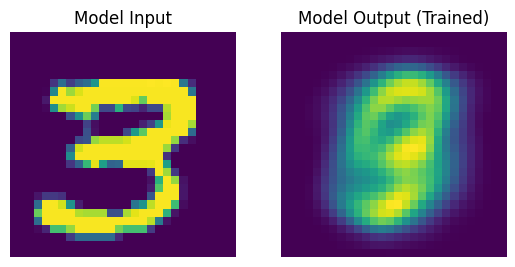

In [ ]:
# Load the trained model and do inference
model = AutoEncoder()
model.load_state_dict(torch.load('autoencoder.pth'))
model.to(device)
model.eval()  # Set the model to evaluation mode

# Load the example from before
examp_img, examp_label =  training_data[111] # I know it was in the training data
examp_img_device = examp_img.to(device)


examp_output_ = model(examp_img_device)
examp_output_cpu_2 = examp_output_.cpu().detach().numpy()
fig, ax = plt.subplots(1,2)
ax[0].imshow(np.squeeze(np.array(examp_img)))
ax[0].axis('off')
ax[0].set_title('Model Input')
ax[1].imshow(np.reshape(np.squeeze(np.array(examp_output_cpu_2)), (28,28)))
ax[1].axis('off')
ax[1].set_title('Model Output (Trained)')





In [ ]:
examp_output_cpu_1 - examp_output_cpu_2

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

Example Image 1 Shape: torch.Size([1, 28, 28]) Sum: 179.77647399902344
Example Image 2 Shape: torch.Size([1, 28, 28]) Sum: 45.80784225463867


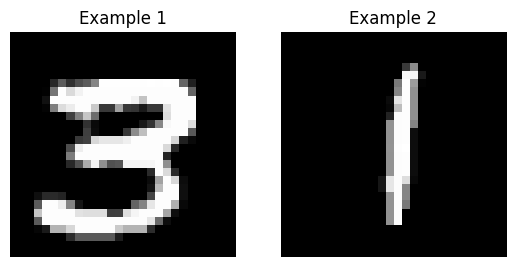

Input to model - Example 1: tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0

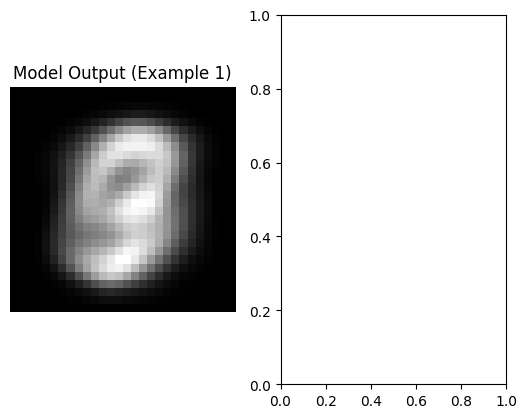

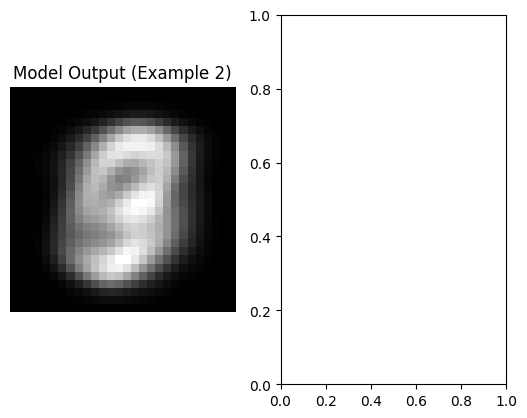

In [ ]:
# Load the trained model and do inference
import torch
import matplotlib.pyplot as plt
import numpy as np

# Assuming AutoEncoder and training_data are already defined and available in the context
model = AutoEncoder()
model.load_state_dict(torch.load('autoencoder.pth'))
model.to(device)
model.eval()  # Set the model to evaluation mode

# Load the first example from the training data
examp_img_1, examp_label_1 = training_data[111]
examp_img_device_1 = examp_img_1.to(device)

# Load the second example from the training data
examp_img_2, examp_label_2 = training_data[112]
examp_img_device_2 = examp_img_2.to(device)

# Ensure the images being loaded are different
print("Example Image 1 Shape:", examp_img_1.shape, "Sum:", examp_img_1.sum().item())
print("Example Image 2 Shape:", examp_img_2.shape, "Sum:", examp_img_2.sum().item())

# Display the images
fig, ax = plt.subplots(1, 2)
ax[0].imshow(np.squeeze(examp_img_1.cpu().numpy()), cmap='gray')
ax[0].axis('off')
ax[0].set_title('Example 1')
ax[1].imshow(np.squeeze(examp_img_2.cpu().numpy()), cmap='gray')
ax[1].axis('off')
ax[1].set_title('Example 2')
plt.show()

# Ensure the inputs to the model are different
print("Input to model - Example 1:", examp_img_device_1)
print("Input to model - Example 2:", examp_img_device_2)

# Get model outputs
examp_output_1 = model(examp_img_device_1)
examp_output_cpu_1 = examp_output_1.cpu().detach().numpy()

examp_output_2 = model(examp_img_device_2)
examp_output_cpu_2 = examp_output_2.cpu().detach().numpy()

# Verify model outputs
print("Example Output 1 Shape:", examp_output_cpu_1.shape, "Sum:", examp_output_cpu_1.sum())
print("Example Output 2 Shape:", examp_output_cpu_2.shape, "Sum:", examp_output_cpu_2.sum())
print("Difference between Outputs:", np.sum(examp_output_cpu_1 - examp_output_cpu_2))

# Plot the first example
fig, ax = plt.subplots(1, 2)
ax[0].imshow(np.reshape(np.squeeze(examp_output_cpu_1), (28, 28)), cmap='gray')
ax[0].axis('off')
ax[0].set_title('Model Output (Example 1)')

# Plot the second example
fig, ax = plt.subplots(1, 2)
ax[0].imshow(np.reshape(np.squeeze(examp_output_cpu_2), (28, 28)), cmap='gray')
ax[0].axis('off')
ax[0].set_title('Model Output (Example 2)')

plt.show()
